# Notebook Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install prince

  Obtaining dependency information for prince from https://files.pythonhosted.org/packages/ea/47/05a78e27a6c7f85b5e006169e4ddf27637867124ef841176f5e4f5ce7f88/prince-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 13.9 MB/s eta 0:00:00


In [3]:
import os
import re
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from prince import MCA
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

# Constants

In [4]:
FILE = '/kaggle/input/data-science-for-good/Dept_11-00091/11-00091_Field-Interviews_2011-2015.csv'

# Step 1: Data Exploration and Preprocessing

### Load data

In [5]:
data = pd.read_csv(FILE)
df_full = pd.DataFrame(data)

df = df_full.sample(frac=0.1)
df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
49978,917371,600871,MALE,WARDMAN RD at WALNUT AV,B2,3,5/20/13 0:00,5/20/13 0:00,YES,B(Black),...,NO DATA ENTERED,11610.0,107106,3,B2,NON,B(Black),51,4754,Roxbury
15531,920600,604121,MALE,123 NORTHAMPTON ST,D4,8,5/29/13 0:00,5/29/13 0:00,YES,H(Hispanic),...,NO DATA ENTERED,11312,93855,16,YVSF,NaN,H(Hispanic),36,3283,Boston
107154,962745,645524,FEMALE,MORTON ST at WOODMERE ST,B3,4,9/11/14 0:00,9/11/14 0:00,NaN,B(Black),...,MA,86124.0,11817,16,YVSF,NaN,B(Black),26,3094,NO DATA ENTERED
132897,890466,573777,MALE,STRATTON ST at WESTVIEW ST,B3,4,6/15/12 0:00,6/15/12 0:00,YES,B(Black),...,NO DATA ENTERED,10739.0,81410,16,YVSF,NaN,B(Black),18,4331,NO DATA ENTERED
84455,925827,609378,MALE,59 LORING ST,E18,10,8/18/13 0:00,8/18/13 0:00,YES,NO DATA ENTERED,...,NO DATA ENTERED,11359.0,11359,10,E18,NaN,NO DATA ENTERED,37,2738,Mattapan


In [6]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")
print(f"The empty row in the data: \n{df.isnull().sum()}")


The shape of the data: (15223, 34)

The types of the data: 
INCIDENT_UNIQUE_IDENTIFIER                      object
INCIDENT_UNIQUE_IDENTIFIER.1                    object
SUBJECT_GENDER                                  object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    object
LOCATION_DISTRICT                               object
LOCATION_DISTRICT.1                             object
INCIDENT_DATE                                   object
INCIDENT_TIME                                   object
SUBJECT_DETAILS                                 object
SUBJECT_RACE                                    object
SUBJECT_DETAILS.1                               object
SUBJECT_DETAILS.2                               object
UNKNOWN_FIELD_TYPE                              object
UNKNOWN_FIELD_TYPE.1                            object
SEARCH_CONDUCTED                                object
SEARCH_REASON                                   object
INCIDENT_REASON                                 object
INCI

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15223 entries, 49978 to 151353
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   INCIDENT_UNIQUE_IDENTIFIER                    15223 non-null  object
 1   INCIDENT_UNIQUE_IDENTIFIER.1                  15223 non-null  object
 2   SUBJECT_GENDER                                15223 non-null  object
 3   LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION  15223 non-null  object
 4   LOCATION_DISTRICT                             15223 non-null  object
 5   LOCATION_DISTRICT.1                           15223 non-null  object
 6   INCIDENT_DATE                                 15223 non-null  object
 7   INCIDENT_TIME                                 15223 non-null  object
 8   SUBJECT_DETAILS                               13155 non-null  object
 9   SUBJECT_RACE                                  15223 non-null  object
 10

### Data Cleaning

In [8]:
# converting 'NO DATA ENTERED', 'UNKNOWN' values in columns to NaN values
for feature in df.columns:
    df[feature].replace(to_replace=["NO DATA ENTERED", 'UNKNOWN', '0', 0, 'FIO_DATE', 'OTHER', 'OTHERS'
                                   'AGE_AT_FIO_CORRECTED', 'DISCRIPTION', 'AGE_AT_FIO_CORRECTED'], value=np.nan, inplace=True)

In [9]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
INCIDENT_UNIQUE_IDENTIFIER                          0
INCIDENT_UNIQUE_IDENTIFIER.1                        0
SUBJECT_GENDER                                     20
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        0
LOCATION_DISTRICT                                   4
LOCATION_DISTRICT.1                                 0
INCIDENT_DATE                                       0
INCIDENT_TIME                                       0
SUBJECT_DETAILS                                  2228
SUBJECT_RACE                                      656
SUBJECT_DETAILS.1                                1326
SUBJECT_DETAILS.2                                2556
UNKNOWN_FIELD_TYPE                                  0
UNKNOWN_FIELD_TYPE.1                                0
SEARCH_CONDUCTED                                13204
SEARCH_REASON                                   11695
INCIDENT_REASON                                  4746
INCIDENT_REASON.1                                   0


In [10]:
# dropping columns where the NaN values were more than 4000
for feature in df.columns:
    if df[feature].isnull().sum() > 4000:
        df.drop([feature], axis=1, inplace=True)

In [11]:
df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER
49978,917371,600871,MALE,WARDMAN RD at WALNUT AV,B2,3,5/20/13 0:00,5/20/13 0:00,YES,B(Black),...,NO,"INVESTIGATE, PERSON",F,11610.0,107106,3,B2,B(Black),51,4754
15531,920600,604121,MALE,123 NORTHAMPTON ST,D4,8,5/29/13 0:00,5/29/13 0:00,YES,H(Hispanic),...,NO,"INVESTIGATE, PERSON",F,11312,93855,16,YVSF,H(Hispanic),36,3283
107154,962745,645524,FEMALE,MORTON ST at WOODMERE ST,B3,4,9/11/14 0:00,9/11/14 0:00,NaN,B(Black),...,NO,"INVESTIGATE, PERSON",F,86124.0,11817,16,YVSF,B(Black),26,3094
132897,890466,573777,MALE,STRATTON ST at WESTVIEW ST,B3,4,6/15/12 0:00,6/15/12 0:00,YES,B(Black),...,NO,"INVESTIGATE, PERSON",F,10739.0,81410,16,YVSF,B(Black),18,4331
84455,925827,609378,MALE,59 LORING ST,E18,10,8/18/13 0:00,8/18/13 0:00,YES,NaN,...,NO,"INVESTIGATE, PERSON",F,11359.0,11359,10,E18,NaN,37,2738


In [12]:
# Number of unique values in the dataset columns
for feature in df.columns:
    print(f'Number of unique values in {feature} column:', len(df[feature].unique()))

Number of unique values in INCIDENT_UNIQUE_IDENTIFIER column: 15223
Number of unique values in INCIDENT_UNIQUE_IDENTIFIER.1 column: 15223
Number of unique values in SUBJECT_GENDER column: 3
Number of unique values in LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION column: 9043
Number of unique values in LOCATION_DISTRICT column: 20
Number of unique values in LOCATION_DISTRICT.1 column: 36
Number of unique values in INCIDENT_DATE column: 1712
Number of unique values in INCIDENT_TIME column: 1712
Number of unique values in SUBJECT_DETAILS column: 3
Number of unique values in SUBJECT_RACE column: 7
Number of unique values in SUBJECT_DETAILS.1 column: 12126
Number of unique values in SUBJECT_DETAILS.2 column: 9
Number of unique values in UNKNOWN_FIELD_TYPE column: 19
Number of unique values in UNKNOWN_FIELD_TYPE.1 column: 2
Number of unique values in INCIDENT_REASON.1 column: 141
Number of unique values in DISPOSITION column: 8
Number of unique values in OFFICER_SUPERVISOR column: 205
Number 

In [13]:
# dropping columns where the unique values were more than 1000
for feature in df.columns:
    if feature != 'LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION' and feature != 'INCIDENT_DATE':
        if len(df[feature].unique()) > 1000:
            df.drop([feature], axis=1, inplace=True)

In [14]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER                                    20
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION       0
LOCATION_DISTRICT                                  4
LOCATION_DISTRICT.1                                0
INCIDENT_DATE                                      0
SUBJECT_DETAILS                                 2228
SUBJECT_RACE                                     656
SUBJECT_DETAILS.2                               2556
UNKNOWN_FIELD_TYPE                                 0
UNKNOWN_FIELD_TYPE.1                               0
INCIDENT_REASON.1                                  0
DISPOSITION                                      938
OFFICER_SUPERVISOR                              1690
OFFICER_ASSIGNMENT                                 0
OFFICER_ASSIGNMENT.1                              42
OFFICER_RACE                                     656
OFFICER_AGE                                       17
dtype: int64


In [15]:
df.shape

(15223, 17)

In [16]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE
49978,MALE,WARDMAN RD at WALNUT AV,B2,3,5/20/13 0:00,YES,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,11610.0,3,B2,B(Black),51
15531,MALE,123 NORTHAMPTON ST,D4,8,5/29/13 0:00,YES,H(Hispanic),Med,O,NO,"INVESTIGATE, PERSON",F,11312,16,YVSF,H(Hispanic),36
107154,FEMALE,MORTON ST at WOODMERE ST,B3,4,9/11/14 0:00,NaN,B(Black),Med,IO,NO,"INVESTIGATE, PERSON",F,86124.0,16,YVSF,B(Black),26
132897,MALE,STRATTON ST at WESTVIEW ST,B3,4,6/15/12 0:00,YES,B(Black),Med,O,NO,"INVESTIGATE, PERSON",F,10739.0,16,YVSF,B(Black),18
84455,MALE,59 LORING ST,E18,10,8/18/13 0:00,YES,NaN,NaN,O,NO,"INVESTIGATE, PERSON",F,11359.0,10,E18,NaN,37


In [17]:
df.drop([ 'UNKNOWN_FIELD_TYPE.1', 'UNKNOWN_FIELD_TYPE', 'DISPOSITION', 'OFFICER_RACE',
        'LOCATION_DISTRICT.1','OFFICER_SUPERVISOR', 'OFFICER_ASSIGNMENT', 'OFFICER_RACE'], axis=1, inplace=True)

In [18]:
df.shape

(15223, 10)

In [19]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE
49978,MALE,WARDMAN RD at WALNUT AV,B2,5/20/13 0:00,YES,B(Black),Med,"INVESTIGATE, PERSON",B2,51
15531,MALE,123 NORTHAMPTON ST,D4,5/29/13 0:00,YES,H(Hispanic),Med,"INVESTIGATE, PERSON",YVSF,36
107154,FEMALE,MORTON ST at WOODMERE ST,B3,9/11/14 0:00,NaN,B(Black),Med,"INVESTIGATE, PERSON",YVSF,26
132897,MALE,STRATTON ST at WESTVIEW ST,B3,6/15/12 0:00,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,18
84455,MALE,59 LORING ST,E18,8/18/13 0:00,YES,NaN,NaN,"INVESTIGATE, PERSON",E18,37


In [20]:
df.duplicated().value_counts()

False    15151
True        72
Name: count, dtype: int64

In [21]:
df.drop_duplicates(inplace=True)

In [22]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER                                    20
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION       0
LOCATION_DISTRICT                                  4
INCIDENT_DATE                                      0
SUBJECT_DETAILS                                 2213
SUBJECT_RACE                                     653
SUBJECT_DETAILS.2                               2546
INCIDENT_REASON.1                                  0
OFFICER_ASSIGNMENT.1                              42
OFFICER_AGE                                       17
dtype: int64


In [23]:
# Handling missing values

mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mode_imputer.fit(df)
imputed_data = mode_imputer.transform(df)
df = pd.DataFrame(data=imputed_data, columns=df.columns)
df.isnull().sum()

SUBJECT_GENDER                                  0
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    0
LOCATION_DISTRICT                               0
INCIDENT_DATE                                   0
SUBJECT_DETAILS                                 0
SUBJECT_RACE                                    0
SUBJECT_DETAILS.2                               0
INCIDENT_REASON.1                               0
OFFICER_ASSIGNMENT.1                            0
OFFICER_AGE                                     0
dtype: int64

### Data Preprocessing

In [24]:
# Extracting dates

df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], format="mixed")
df["INCIDENT_YEAR"] = df["INCIDENT_DATE"].dt.strftime('%Y')
df["INCIDENT_MONTH"] = df["INCIDENT_DATE"].dt.strftime('%B')

df.drop(['INCIDENT_DATE'], axis=1, inplace=True)

In [25]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,WARDMAN RD at WALNUT AV,B2,YES,B(Black),Med,"INVESTIGATE, PERSON",B2,51,2013,May
1,MALE,123 NORTHAMPTON ST,D4,YES,H(Hispanic),Med,"INVESTIGATE, PERSON",YVSF,36,2013,May
2,FEMALE,MORTON ST at WOODMERE ST,B3,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,26,2014,September
3,MALE,STRATTON ST at WESTVIEW ST,B3,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,18,2012,June
4,MALE,59 LORING ST,E18,YES,B(Black),Med,"INVESTIGATE, PERSON",E18,37,2013,August


In [26]:
# replace weird years
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(int)
replace = df[(df['INCIDENT_YEAR'] < 2011) | (df['INCIDENT_YEAR'] > 2015)]['INCIDENT_YEAR'].tolist()
value = round(df[(df['INCIDENT_YEAR'] >= 2011) | (df['INCIDENT_YEAR'] <= 2015)]['INCIDENT_YEAR'].mean())
df['INCIDENT_YEAR'].replace(to_replace=replace, value=value, inplace=True)

In [27]:
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(str)
df['INCIDENT_YEAR'].value_counts()

INCIDENT_YEAR
2012    3887
2013    3486
2011    3465
2014    3383
2015     930
Name: count, dtype: int64

In [28]:
list_ = df['INCIDENT_REASON.1'].unique().tolist()

dict_ = {
    'DRUGS': ['DRUGS', 'OVERDOSE'],
    '209A':  ['209A'],
    'ASSAULT': ['ASSAULT', 'A&B'],
    'SEXUAL OFFENDER': ['SEXUAL', 'OFFENDER', 'SEX-ASSAULT', 'RAPE', 'SEX'],
    'PROSTITUTION': ['PROSTITUTION'],
    'ALCOHOL': ['PUBLIC', 'DRINKING', 'ALCOHOL'],
    'ABDW': ['ABDW', 'A D/W'],
    'B&E': ['B&E'], 
    'MV': ['MV', 'M/V'], 
    'ROBBERY': ['ROBBERY', 'LARCENY', 'STOLEN'],
    'DISTURBING': ['DISTURBING', 'PEACE', 'LOUD', 'PARTY', 'DISTURBANCE', 'NOISYHOUSE', 'NOISE'], 
    'FIREARM': ['FIREARM', 'FIRE'], 
    'HIT & RUN': ['HIT', 'RUN'],
    'SEARCH WARRANT': ['SEARCH', 'WARRANT', 'WARRANTS'],
    'THREATS': ['THREATS', 'THREAT'],
    'CITY ORDINANCES': ['CITY', 'ORDINANCES'],
    'MISSING PERSON': ['MISSING'],
    'DISORDERLY': ['DISORDERLY', 'UNNATURAL', 'LACIVIOUS'],
    'PROPERTY DAMAGE': ['PROPERTY', 'DAMAGE'], 
    'HARASSMENT': ['HARASSMENT']
}

for item in list_:
    for key, values in dict_.items():            
        if any(value in item for value in values):
            df['INCIDENT_REASON.1'].replace(item, value=key, inplace=True)                 
            break 

# Find values with counts less than or equal to 4
infrequent_values = df['INCIDENT_REASON.1'].value_counts()[df['INCIDENT_REASON.1'].value_counts() <= 4].index

# Replace those infrequent values with 'OTHERS'
df['INCIDENT_REASON.1'] = df['INCIDENT_REASON.1'].replace(infrequent_values, 'OTHERS')

In [29]:
len(df['INCIDENT_REASON.1'].value_counts())

32

In [30]:
# replace weird ages 
df['OFFICER_AGE'] = df['OFFICER_AGE'].astype(int)
replace = df[(df['OFFICER_AGE'] < 15) | (df['OFFICER_AGE'] > 75)]['OFFICER_AGE'].tolist()
value = round(df[(df['OFFICER_AGE'] >= 15) | (df['OFFICER_AGE'] <= 75)]['OFFICER_AGE'].mean())
df['OFFICER_AGE'].replace(to_replace=replace, value=value, inplace=True)

# Define a dictionary of age group labels
age_groups = {
    '15-19': range(15, 20),
    '20-29': range(20, 30),
    '30-39': range(30, 40),
    '40-49': range(40, 50),
    '50-59': range(50, 60),
    '60-69': range(60, 70),
    '70+': range(70, 110),  # Assuming 70 and above
}

# Iterate through the age group labels and replace values in the DataFrame
for age_group, age_range in age_groups.items():
    df['OFFICER_AGE'] = df['OFFICER_AGE'].replace(age_range, age_group)

In [31]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,WARDMAN RD at WALNUT AV,B2,YES,B(Black),Med,"INVESTIGATE, PERSON",B2,50-59,2013,May
1,MALE,123 NORTHAMPTON ST,D4,YES,H(Hispanic),Med,"INVESTIGATE, PERSON",YVSF,30-39,2013,May
2,FEMALE,MORTON ST at WOODMERE ST,B3,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,20-29,2014,September
3,MALE,STRATTON ST at WESTVIEW ST,B3,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,15-19,2012,June
4,MALE,59 LORING ST,E18,YES,B(Black),Med,"INVESTIGATE, PERSON",E18,30-39,2013,August


In [32]:
addresses = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].unique().tolist()

street_name_mapping = {}

# Iterate through the addresses and extract street names
for address in addresses:
    parts = address.split(' at ', 1)  # Split at 'at'
    modified_address = parts[0].strip()

    match = re.search(r'[^0-9]+$', modified_address)
    if match:
        old_street_name = address
        new_street_name = match.group(0).strip()  # Remove leading/trailing spaces
        street_name_mapping[old_street_name] = new_street_name

# Use the .replace() method to replace old street names with new names
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].replace(street_name_mapping)

# Find values with counts less than or equal to 1
infrequent_values = df['LOCATION_STREET_ADDRESS'].value_counts()[df['LOCATION_STREET_ADDRESS'].value_counts() <= 1].index

# Replace those infrequent values with 'OTHERS'
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_STREET_ADDRESS'].replace(infrequent_values, 'OTHERS')

In [33]:
df.drop(['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'], axis=1, inplace=True)
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,MALE,B2,YES,B(Black),Med,"INVESTIGATE, PERSON",B2,50-59,2013,May,WARDMAN RD
1,MALE,D4,YES,H(Hispanic),Med,"INVESTIGATE, PERSON",YVSF,30-39,2013,May,NORTHAMPTON ST
2,FEMALE,B3,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,20-29,2014,September,MORTON ST
3,MALE,B3,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,15-19,2012,June,STRATTON ST
4,MALE,E18,YES,B(Black),Med,"INVESTIGATE, PERSON",E18,30-39,2013,August,OTHERS


In [34]:
for feature in df.columns:
    print(f'Number of unique values in {feature} column:', len(df[feature].unique()))

Number of unique values in SUBJECT_GENDER column: 2
Number of unique values in LOCATION_DISTRICT column: 19
Number of unique values in SUBJECT_DETAILS column: 2
Number of unique values in SUBJECT_RACE column: 6
Number of unique values in SUBJECT_DETAILS.2 column: 8
Number of unique values in INCIDENT_REASON.1 column: 32
Number of unique values in OFFICER_ASSIGNMENT.1 column: 23
Number of unique values in OFFICER_AGE column: 7
Number of unique values in INCIDENT_YEAR column: 5
Number of unique values in INCIDENT_MONTH column: 12
Number of unique values in LOCATION_STREET_ADDRESS column: 1093


In [35]:
df.duplicated().value_counts()
print(df.duplicated().value_counts())
df.drop_duplicates(inplace=True)

False    14711
True       440
Name: count, dtype: int64


In [36]:
df.shape

(14711, 11)

### Data Encoding

In [37]:
df.dtypes

SUBJECT_GENDER             object
LOCATION_DISTRICT          object
SUBJECT_DETAILS            object
SUBJECT_RACE               object
SUBJECT_DETAILS.2          object
INCIDENT_REASON.1          object
OFFICER_ASSIGNMENT.1       object
OFFICER_AGE                object
INCIDENT_YEAR              object
INCIDENT_MONTH             object
LOCATION_STREET_ADDRESS    object
dtype: object

In [38]:
encoded_df = df.copy()

for feature in encoded_df.columns:
    encoded_df[feature] = encoded_df[feature].astype(str)

label_encoder = LabelEncoder()
for column in encoded_df.columns:
    encoded_df[column] = label_encoder.fit_transform(encoded_df[column])

In [39]:
encoded_df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,1,4,1,1,5,17,4,4,2,8,1012
1,1,12,1,2,5,17,22,2,2,8,720
2,0,5,1,1,5,17,22,1,3,11,680
3,1,5,1,1,5,17,22,0,1,6,904
4,1,15,1,1,5,17,16,2,2,1,744


# Step 2: Exploratory Data Analysis (EDA)

### Gender and Race Distribution

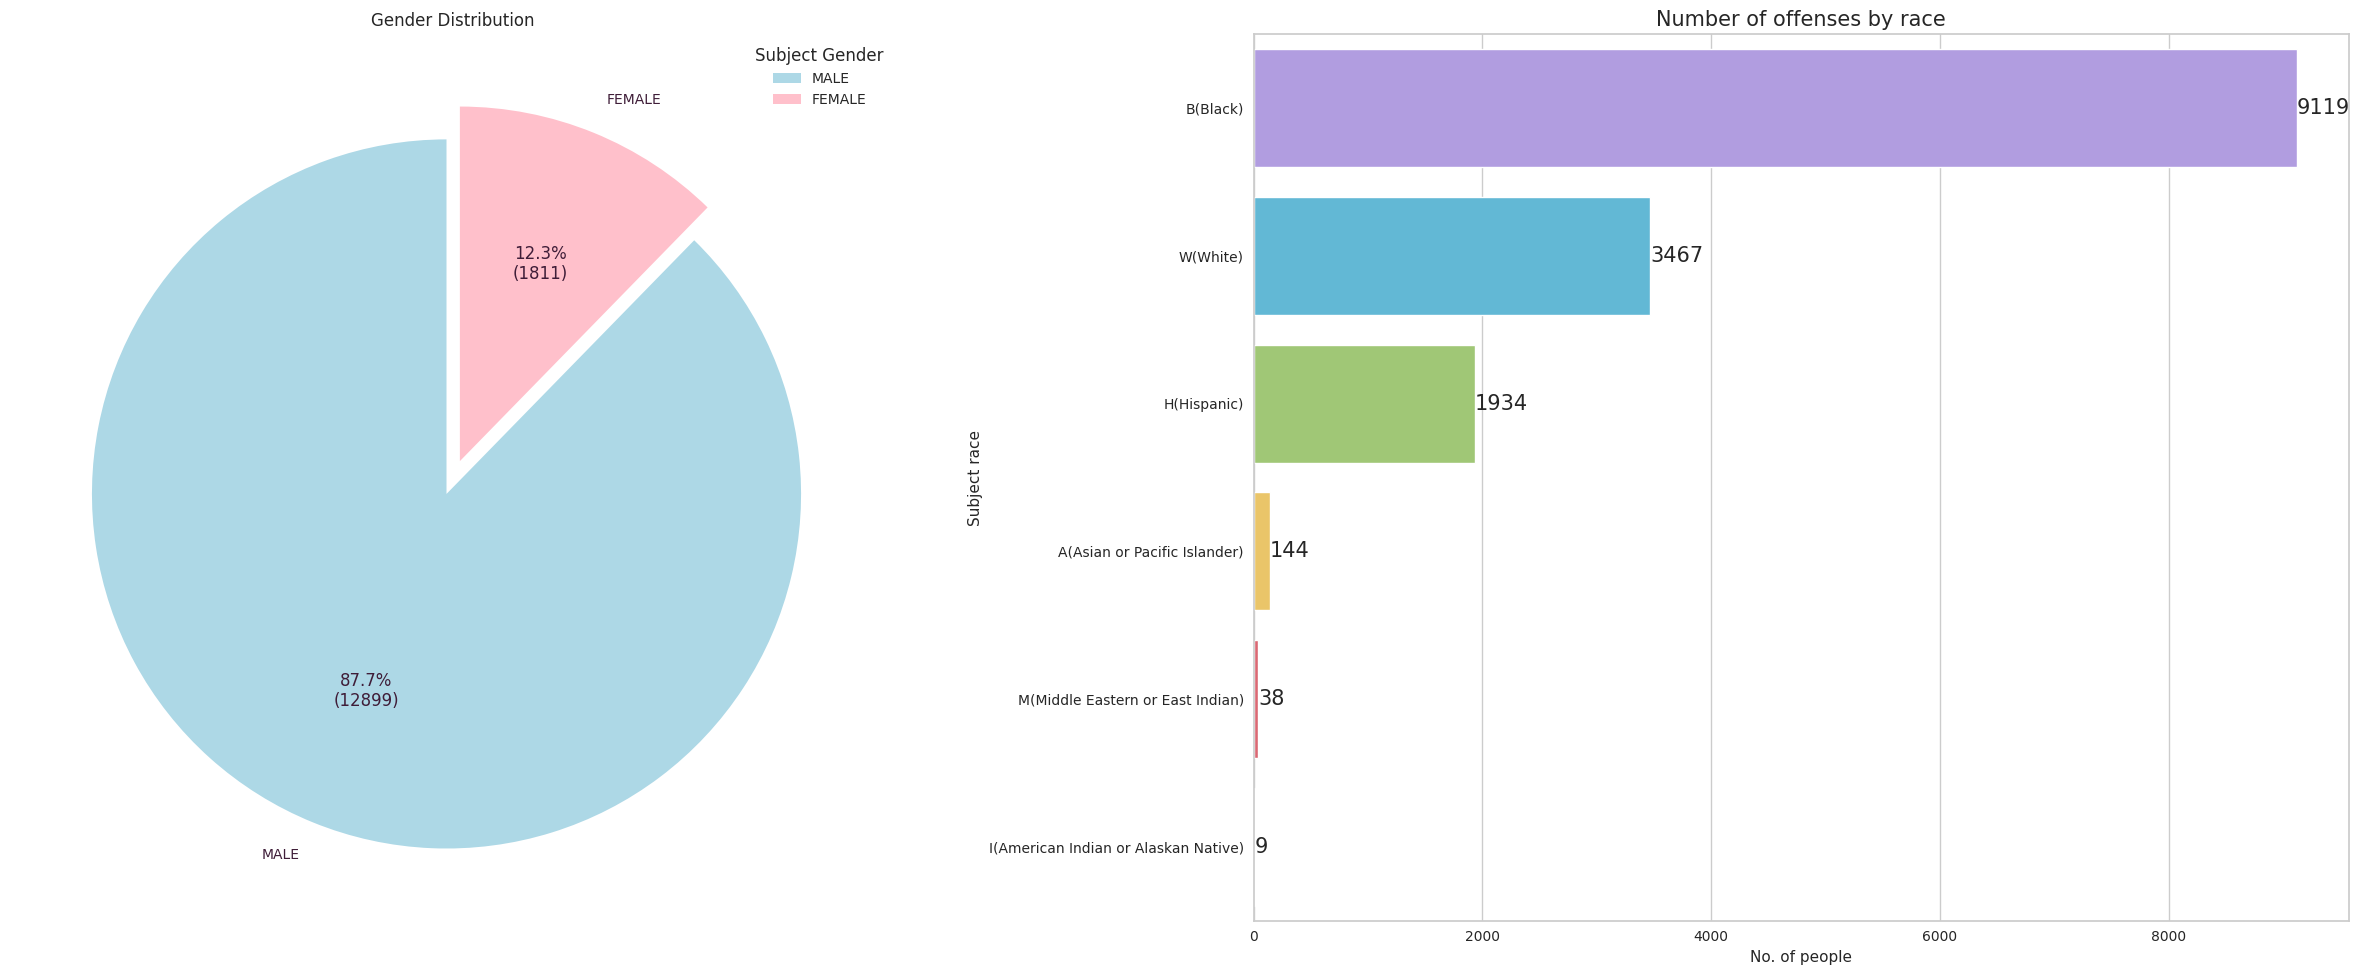

In [40]:
data = [len(df[df['SUBJECT_GENDER'] == feature]) for feature in df['SUBJECT_GENDER'].value_counts().index[0:2]]
labels = ['MALE', 'FEMALE']

colors = ['lightblue', 'pink']
explode = (0.05, 0.05)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.legend(labels, title="Subject Gender")
plt.title("Gender Distribution")

# Creating the bar chart
plt.subplot(1, 2, 2)
order = df['SUBJECT_RACE'].value_counts().index
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(data=df, y='SUBJECT_RACE', order=order, palette=colors) 

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offenses by race')
plt.ylabel('Subject race')
plt.xlabel('No. of people')

# Show plots
plt.tight_layout()
plt.show()

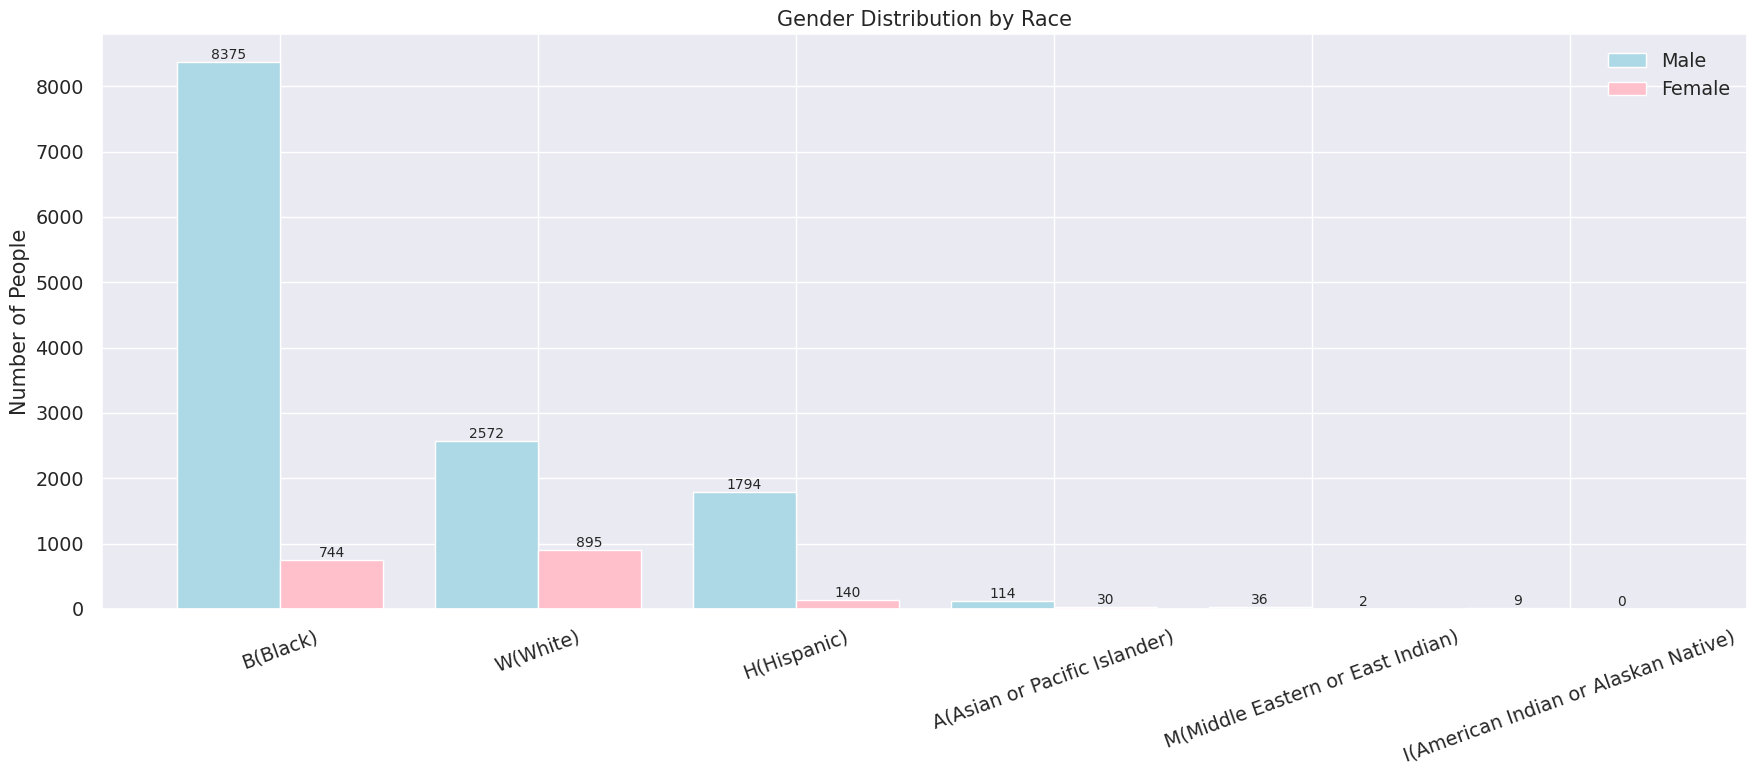

In [41]:
# Set the figure size
plt.figure(figsize=(18, 8))

# Extract the unique race categories to plot
race_to_plot = df['SUBJECT_RACE'].value_counts().index

# Filter data for male and female subjects
male = df[df['SUBJECT_GENDER'] == 'MALE']
female = df[df['SUBJECT_GENDER'] == 'FEMALE']

# Count the occurrences of gender and race combinations for male and female
male_counts = male['SUBJECT_RACE'].value_counts().reindex(race_to_plot, fill_value=0)
female_counts = female['SUBJECT_RACE'].value_counts().reindex(race_to_plot, fill_value=0)

# Set up positions for the bars
x = np.arange(len(race_to_plot))
width = 0.4  # Width of the bars
colors = ['lightblue', 'pink']  # Colors for male and female bars

# Create the bar plots
plt.bar(x - width/2, male_counts, width, color=colors[0], label='Male')
plt.bar(x + width/2, female_counts, width, color=colors[1], label='Female')

# Annotate the bars with their values
for i in range(len(race_to_plot)):
    plt.text(x[i] - width/2, male_counts[i], str(male_counts[i]), ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width/2, female_counts[i], str(female_counts[i]), ha='center', va='bottom', fontsize=10)

# Set the x-axis labels and tick rotation
plt.xticks(x, race_to_plot, rotation=20)

# Set labels, legend, and title
plt.ylabel("Number of People")
plt.legend()
plt.title("Gender Distribution by Race")

# Display the plot
plt.tight_layout()
plt.show()

### Number of offences distrubuted by Years and Months

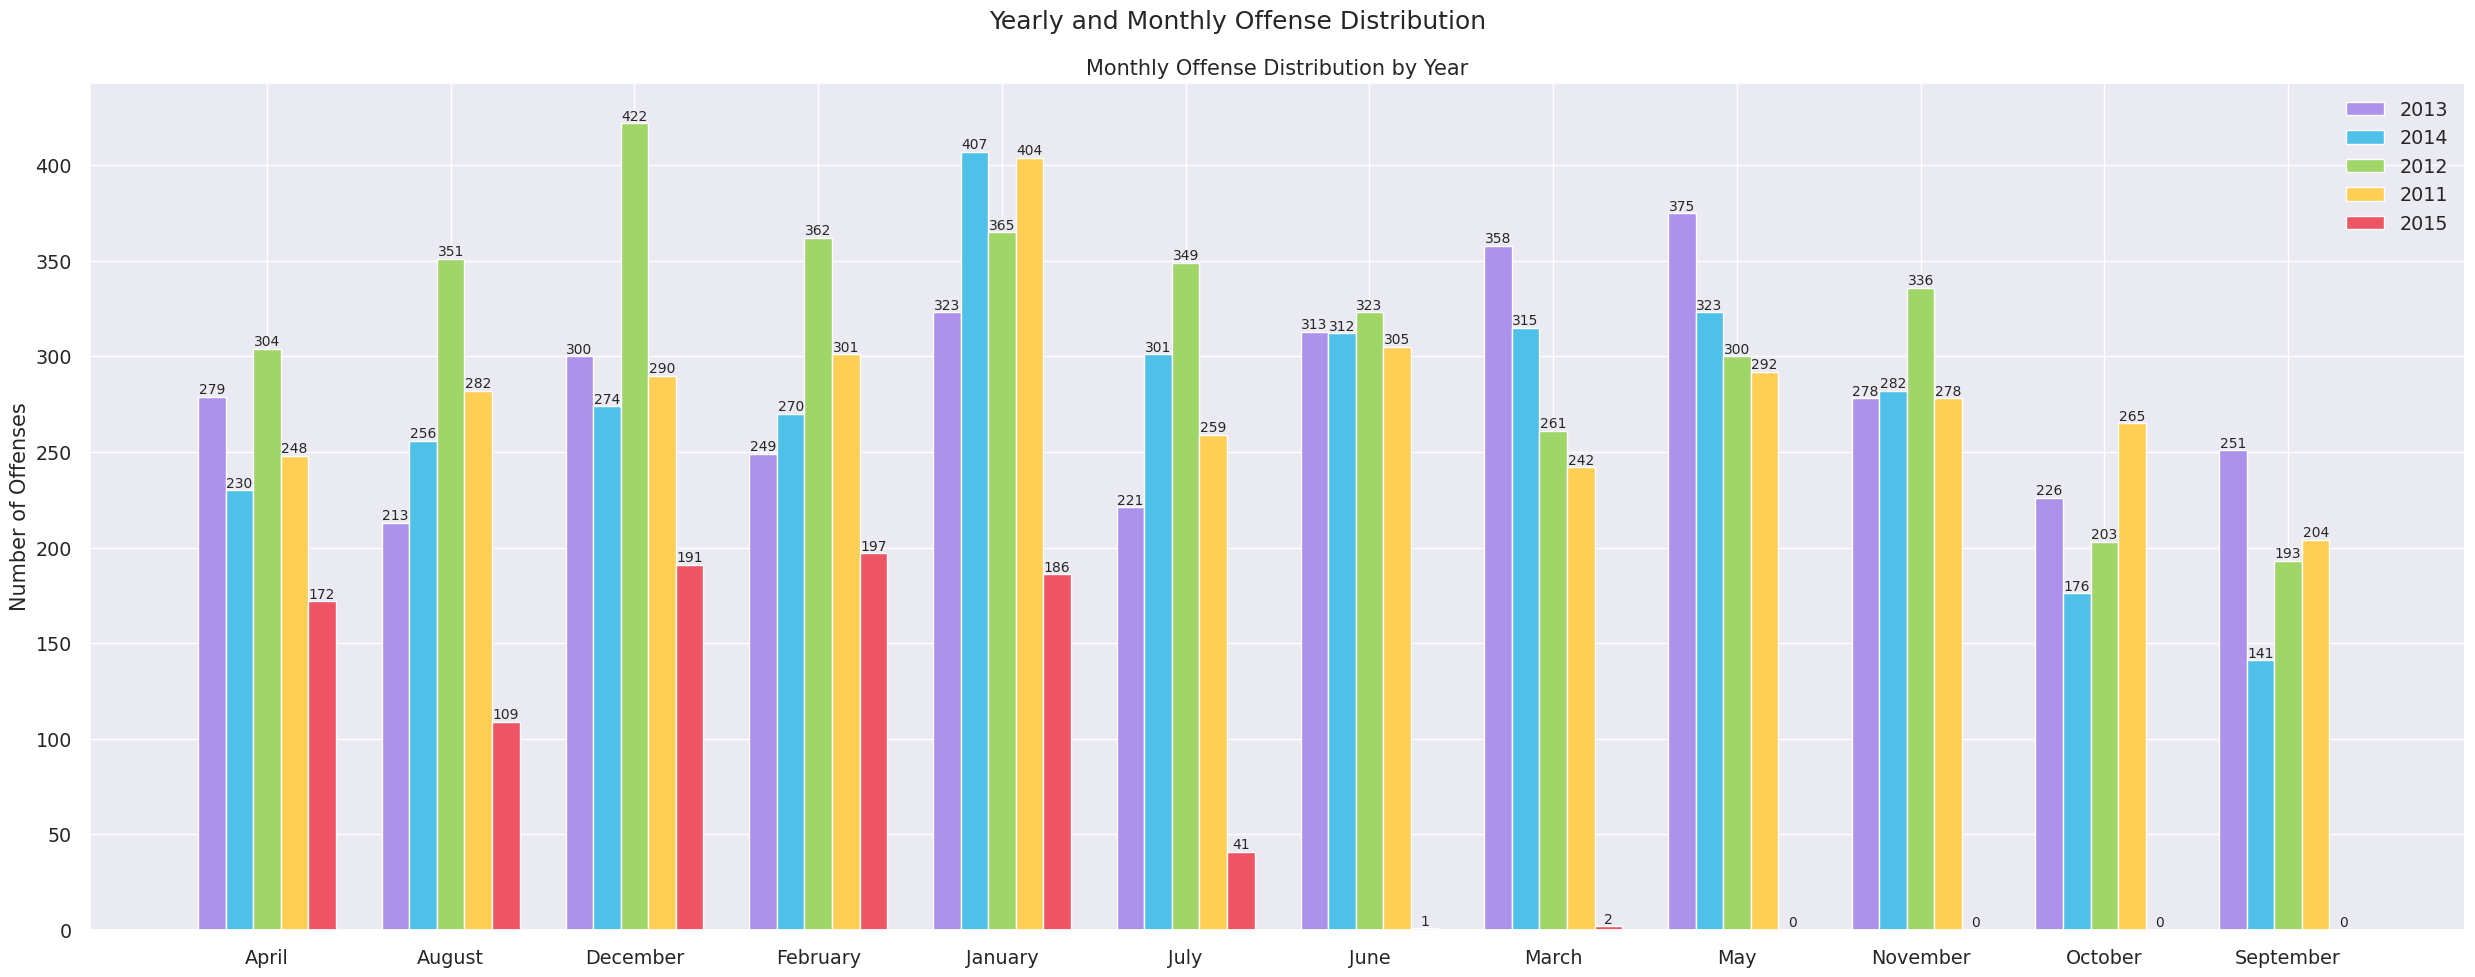

In [42]:
# Get unique years in your data
years_to_plot = df['INCIDENT_YEAR'].unique()

# Create a mapping from month names to their numeric values
month_name_to_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# An empty list to store monthly counts for each year
values = []

for year in years_to_plot:
    c = df[df['INCIDENT_YEAR'] == year]
    value = c['INCIDENT_MONTH'].map(month_name_to_number)  # Map month names to numbers
    value_counts = value.value_counts().sort_index()

    # Create an empty list to store the counts for all 12 months
    monthly_counts = [0] * 12
    
    # Fill in the counts for the months that exist
    for month, count in value_counts.items():
        monthly_counts[month - 1] = count  # Subtract 1 to adjust for zero-based indexing

    values.append(monthly_counts)

x = np.arange(1, 13)
width = 0.15
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564']

plt.figure(figsize=(25, 10))
for n in range(len(years_to_plot)):
    plt.bar(x + (n - 2) * width, values[n], width=width, color=colors[n])

# Annotate the bars with their values
for n in range(len(years_to_plot)):
    for i in range(12):
        plt.text(x[i] + (n - 2) * width, values[n][i], str(values[n][i]), ha='center', va='bottom', fontsize=10)

order = df['INCIDENT_MONTH'].value_counts().sort_index().index
plt.xticks(x, order)
plt.ylabel("Number of Offenses")
plt.legend(years_to_plot)  # Use the extracted unique years
plt.title("Monthly Offense Distribution by Year")

# Adding an overall title to the entire figure
plt.suptitle("Yearly and Monthly Offense Distribution")

# Show plots
plt.tight_layout()
plt.show()

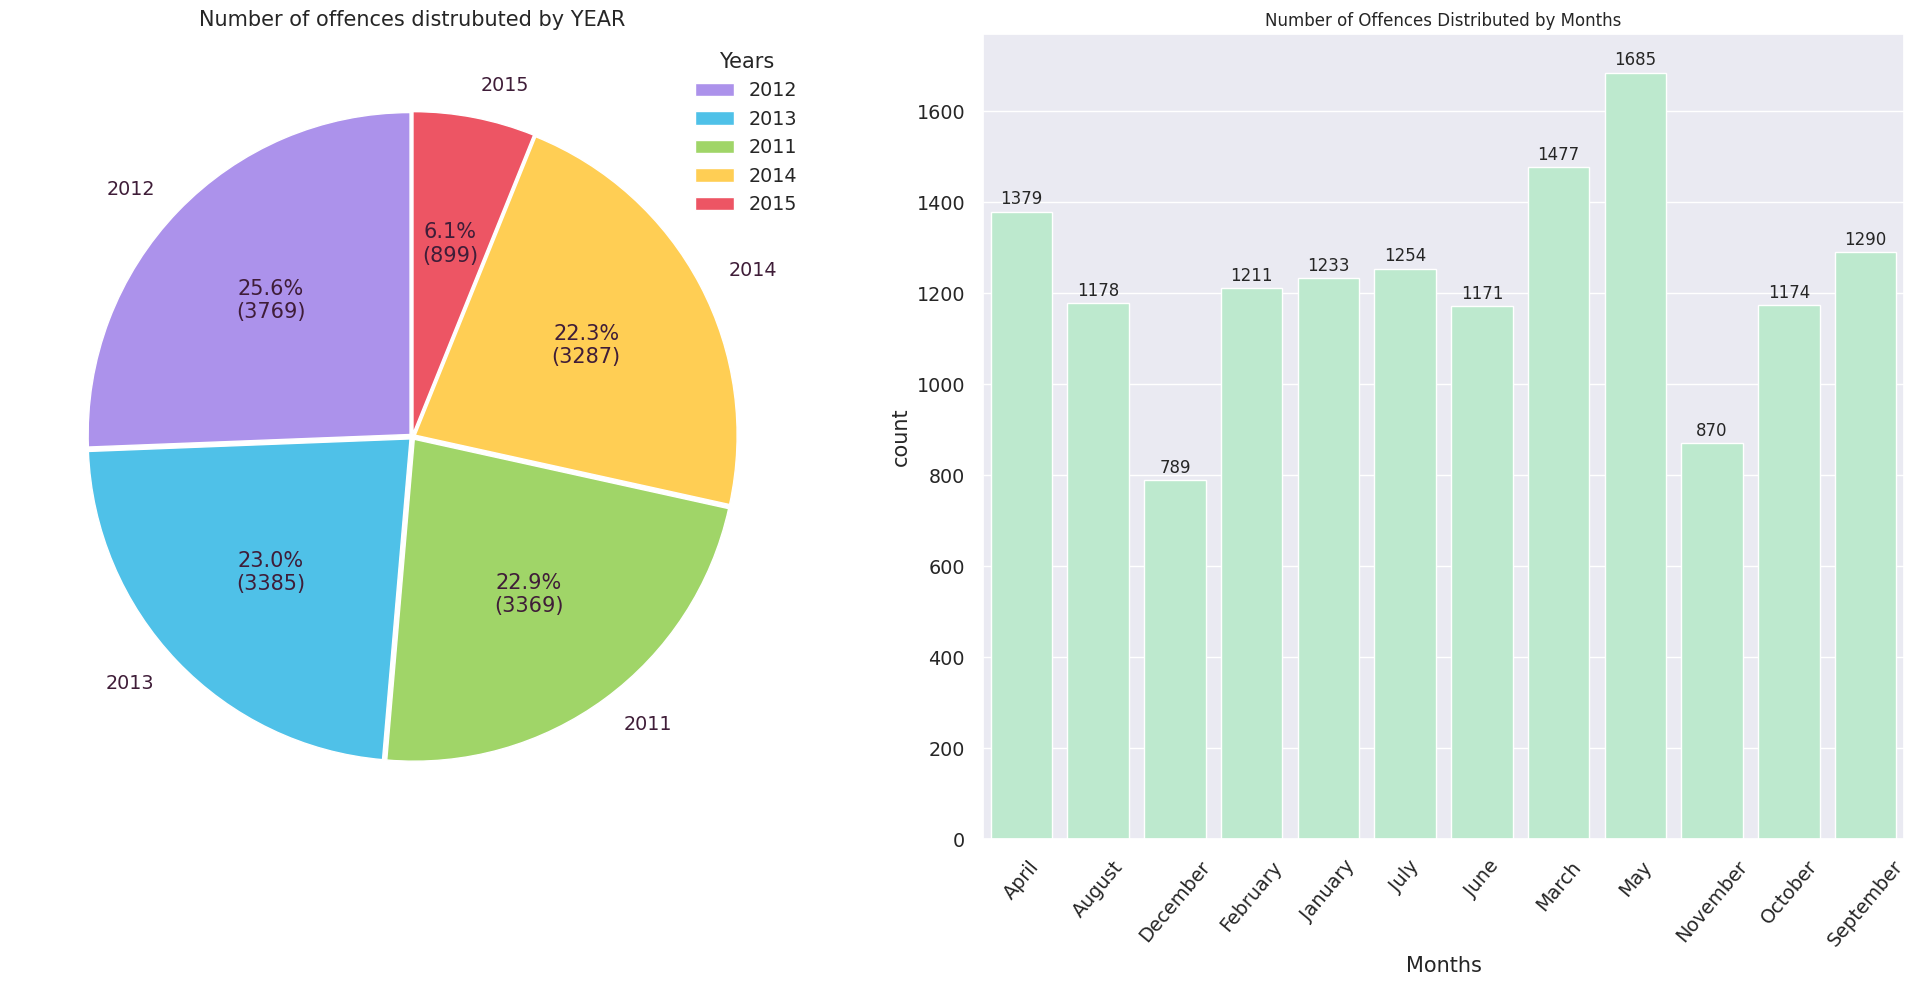

In [43]:
# Pie Chart

# Creating data
data = [len(df[df['INCIDENT_YEAR'] == feature]) for feature in df['INCIDENT_YEAR'].value_counts().index]
labels = df['INCIDENT_YEAR'].value_counts().index

colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564'] # creating color parameters
explode = (0.01, 0.01, 0.01, 0.01, 0.01) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, autopct=lambda pct: func(pct, data), 
        startangle=90, textprops=dict(color ="#3F1D38"))

# Adding legend
plt.legend(labels, title ="Years", loc ='best',)

plt.title("Number of offences distrubuted by YEAR")

# Bat chart
plt.subplot(1, 2, 2)
order = df['INCIDENT_MONTH'].value_counts().sort_index().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='INCIDENT_MONTH', order=order, color='#B5F1CC') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('Number of Offences Distributed by Months')
plt.xlabel('Months')

plt.tight_layout() 
plt.show()

### Number of Offences Distributed by Location

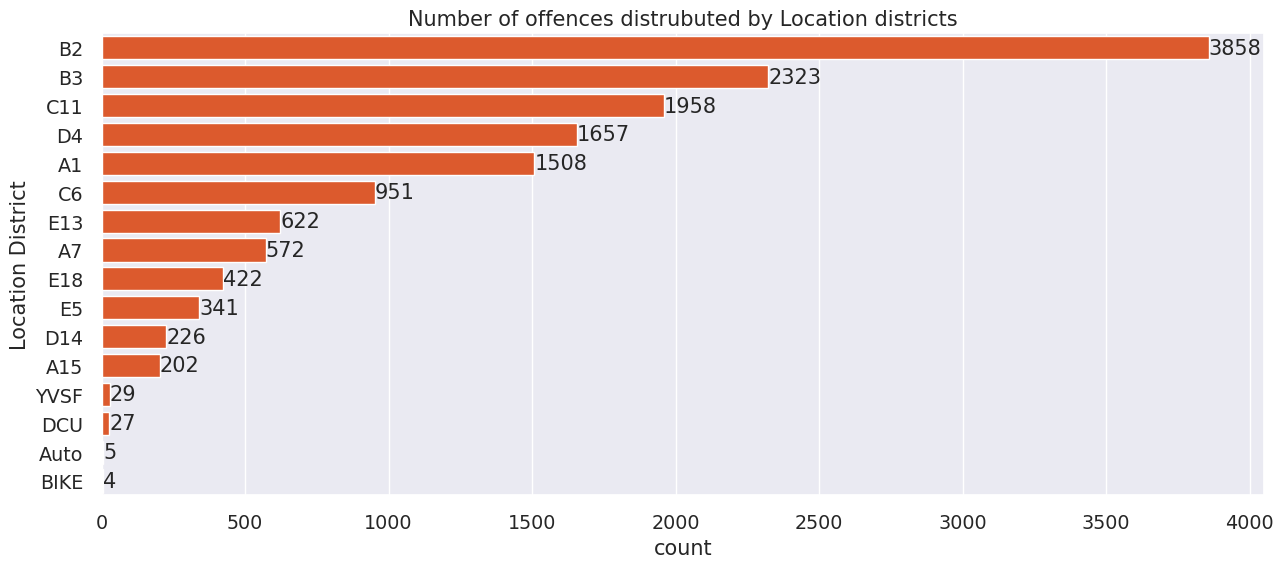

In [44]:
# Bar chart 1: Location district
plt.figure(figsize=(15, 6))
order = df['LOCATION_DISTRICT'].value_counts().index[0:16]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_DISTRICT'], order=order, color='#F94C10')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by Location districts')
plt.ylabel('Location District')

plt.show()

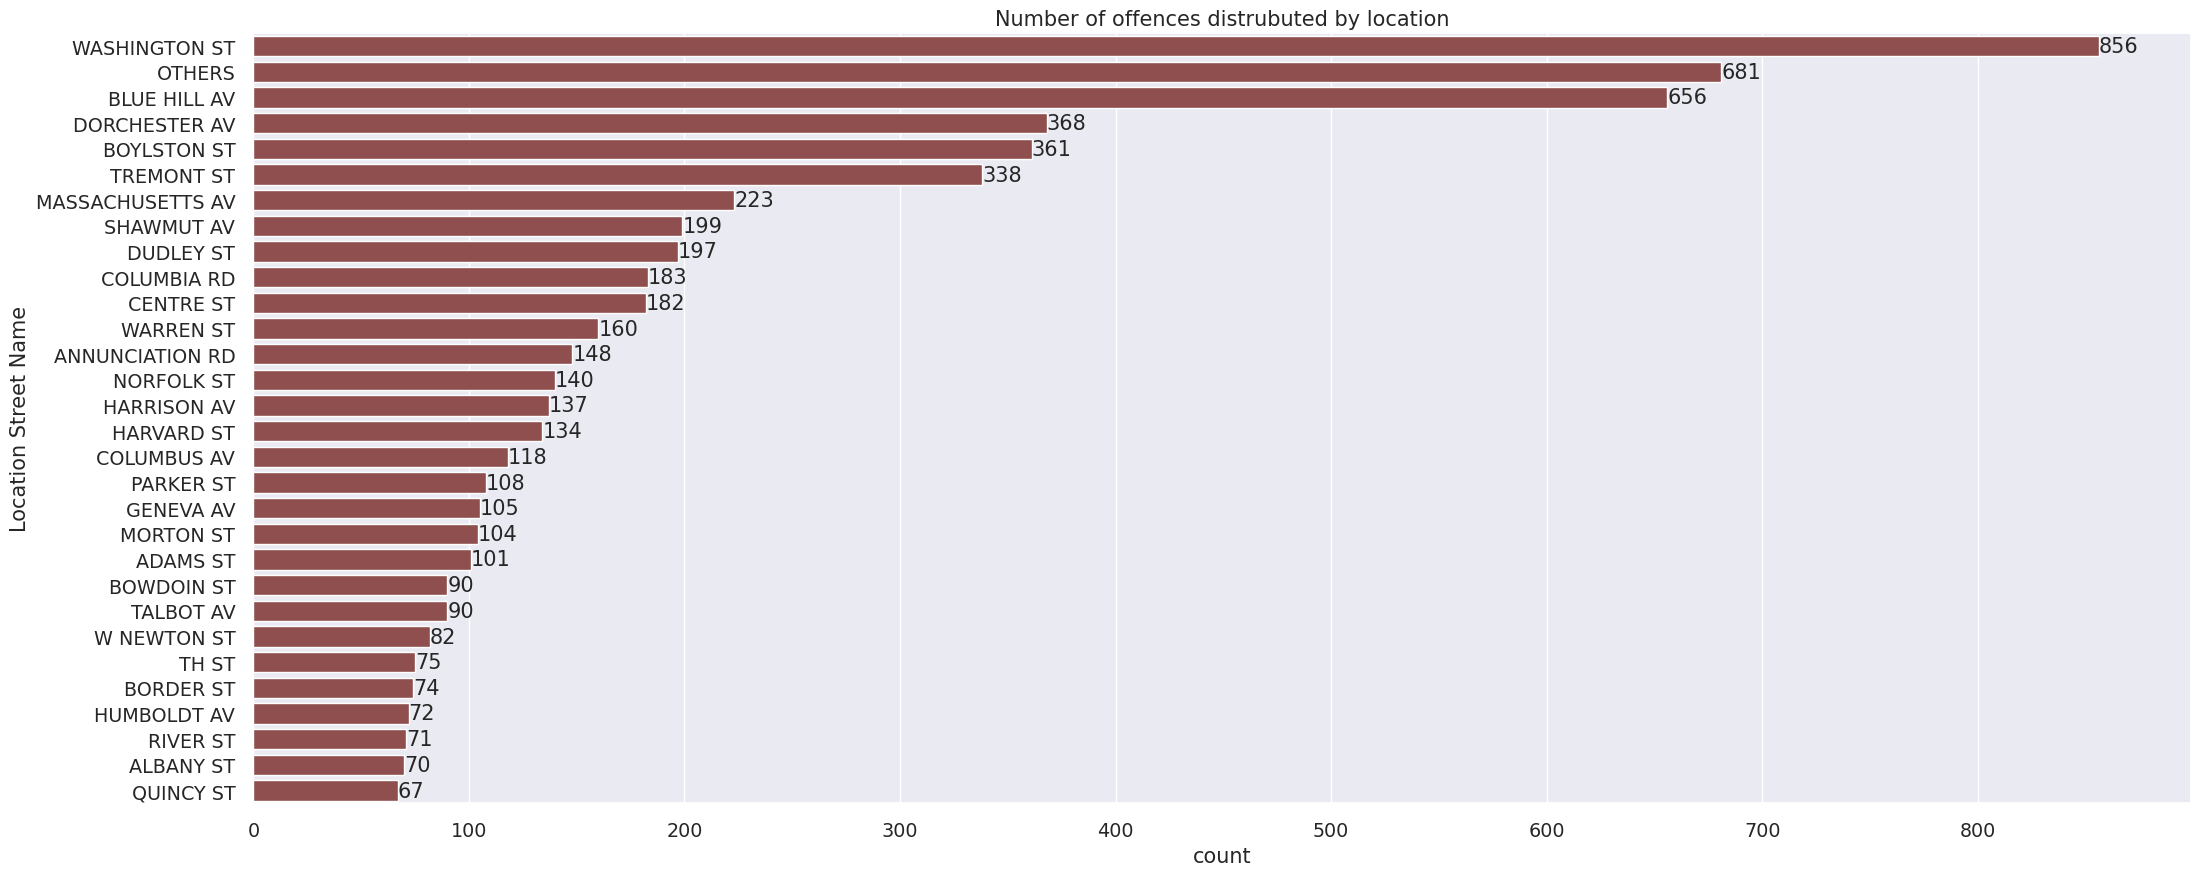

In [45]:
# Bar chart: Location
plt.figure(figsize=(25, 10))
order = df['LOCATION_STREET_ADDRESS'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_STREET_ADDRESS'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by location')
plt.ylabel('Location Street Name')

plt.show()

### Officer Related Information

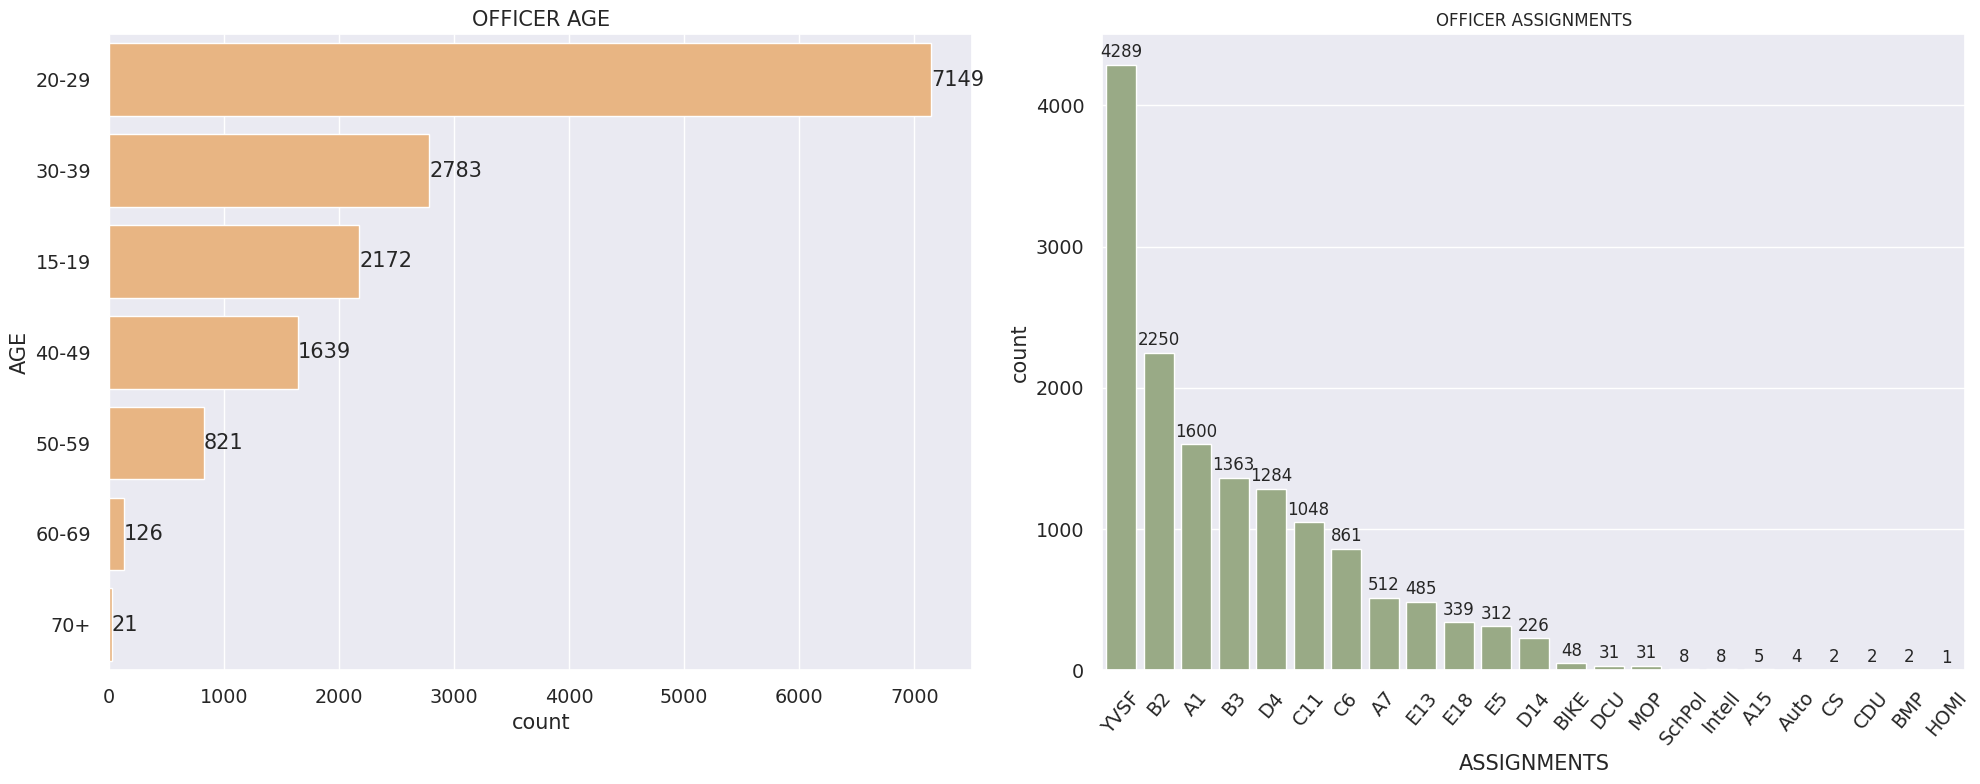

In [46]:
# Creating data
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
order = df['OFFICER_AGE'].value_counts().index[:12]
ax = sns.countplot(y=df['OFFICER_AGE'], order=order, color='#F9B572')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('AGE')
plt.title("OFFICER AGE")

# Bat chart
plt.subplot(1, 2, 2)
order = df['OFFICER_ASSIGNMENT.1'].value_counts().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='OFFICER_ASSIGNMENT.1', order=order, color='#99B080') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('OFFICER ASSIGNMENTS')
plt.xlabel('ASSIGNMENTS')

plt.tight_layout() 
plt.show()

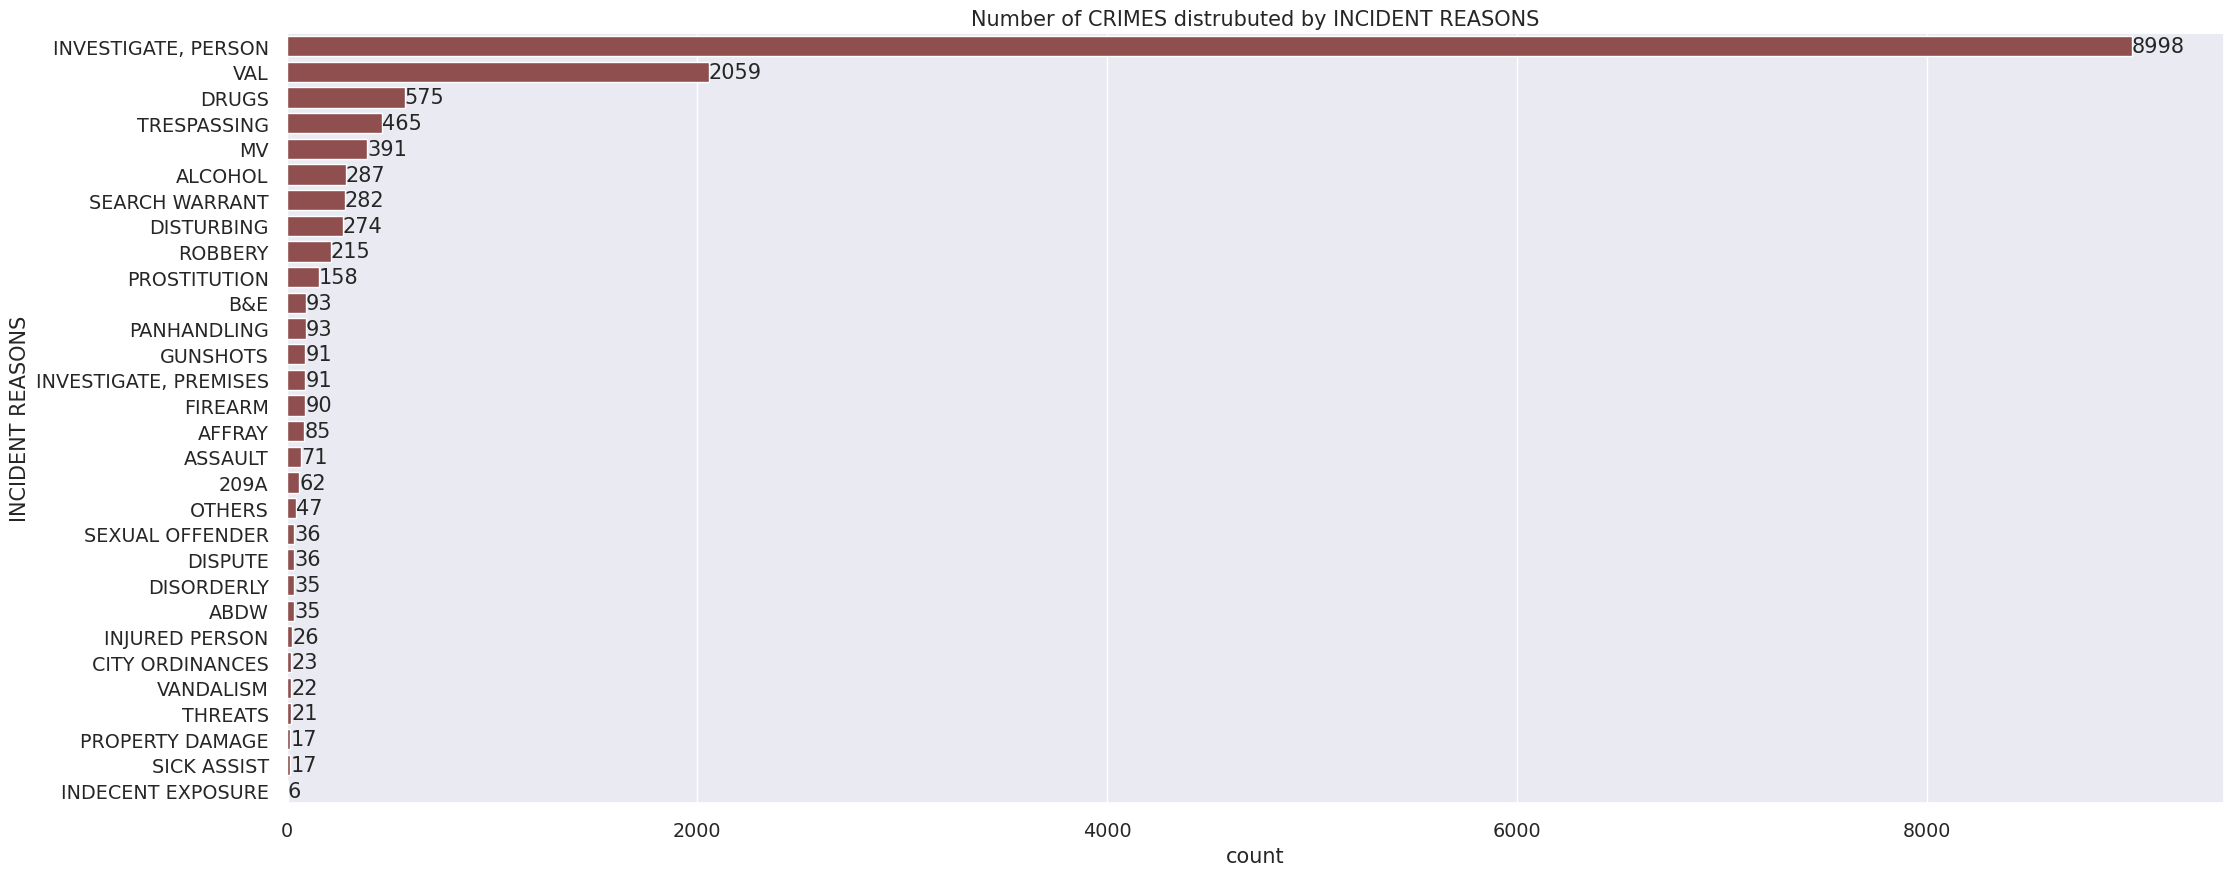

In [47]:
# Bar chart 1: Location
plt.figure(figsize=(25, 10))
order = df['INCIDENT_REASON.1'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['INCIDENT_REASON.1'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of CRIMES distrubuted by INCIDENT REASONS')
plt.ylabel('INCIDENT REASONS')

plt.show()

# Step 3: Dimensionality Reduction

In [48]:
# 81% percent
mca = MCA(n_components=950, n_iter=50, copy=True, check_input=True, random_state=42, one_hot=True)
mca_results = mca.fit(encoded_df)

In [49]:
mca_results.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.315,0.29%,0.29%
1,0.267,0.25%,0.53%
2,0.258,0.24%,0.77%
3,0.246,0.23%,1.00%
4,0.242,0.22%,1.22%
...,...,...,...
945,0.091,0.08%,82.64%
946,0.091,0.08%,82.72%
947,0.091,0.08%,82.81%


In [50]:
mca_data = mca.transform(encoded_df)
mca_data

,0,1,2,3,4,5,6,7,8,9,...,940,941,942,943,944,945,946,947,948,949
0,-0.316063,-0.081187,-0.131951,-0.143116,0.050166,-0.101644,0.286829,-0.264642,0.879621,-0.135316,...,9.079234e-03,1.709919e-01,-4.105177e-01,-4.178062e-01,0.408950,0.180117,-0.026775,-0.343221,4.176251e-02,-3.447959e-01
1,0.033477,-0.046666,-0.314053,-0.250407,0.446378,-0.337526,0.628024,0.393815,-0.247904,0.202927,...,-7.020499e-02,2.027852e-01,5.401298e-02,-1.184502e-01,-0.041358,-0.412432,0.233090,-0.012293,-1.590003e-01,-9.887110e-02
2,-0.486676,0.003935,0.175590,-0.094660,-0.181909,-0.058310,-0.266570,-0.142162,-0.323054,0.552220,...,-4.756786e-02,-8.455604e-02,-1.186294e-01,-1.946506e-01,-0.130770,0.182520,-0.056785,0.064257,-1.655797e-02,-1.971386e-02
3,-0.592486,0.085145,0.134710,-0.063570,-0.174108,-0.186616,-0.249714,-0.116368,-0.386536,0.517334,...,-3.605311e-01,1.768671e-01,-6.405336e-02,3.331013e-01,0.105921,-0.267315,0.332272,-0.131086,-1.954156e-01,-2.346497e-01
4,-0.127787,0.127153,0.063218,1.306628,-0.643653,-0.755690,-0.344303,1.298870,0.181606,-0.432538,...,4.755913e-02,2.129619e-02,4.107601e-02,-6.682969e-02,0.092987,-0.034077,0.026638,-0.072167,-4.469943e-02,4.003828e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15146,-0.211767,0.104388,-0.065635,-0.157958,0.208792,-0.190880,0.285118,0.000600,0.100857,-0.173666,...,-4.733208e-07,-3.327394e-07,2.483096e-07,-5.281505e-07,-0.000002,-0.000002,-0.000002,-0.000002,2.953443e-07,-5.698872e-07
15147,0.305088,-0.017506,-0.223335,0.375311,-0.148656,0.089663,0.461594,-0.258844,1.409055,0.980134,...,-4.865401e-02,-5.125116e-02,1.647358e-02,-2.460787e-02,-0.016401,-0.026051,0.003638,-0.001308,3.964960e-02,-2.679804e-02
15148,-0.272143,-0.113092,-0.133246,-0.126139,0.135882,-0.164135,0.254810,0.118812,-0.172229,0.125347,...,-4.865477e-02,-5.125112e-02,1.647312e-02,-2.460713e-02,-0.016402,-0.026052,0.003638,-0.001309,3.964838e-02,-2.679189e-02
15149,-0.532649,-0.035798,-0.001023,-0.177436,0.060669,-0.081936,0.035191,-0.105543,0.192402,-0.469885,...,2.577464e-01,3.175692e-01,1.039510e-01,-4.190976e-01,-0.277313,0.207354,-0.332331,-0.128893,-1.390421e-02,2.615202e-02


# Step 4: Clustering

### Choosing the Number of clusters k

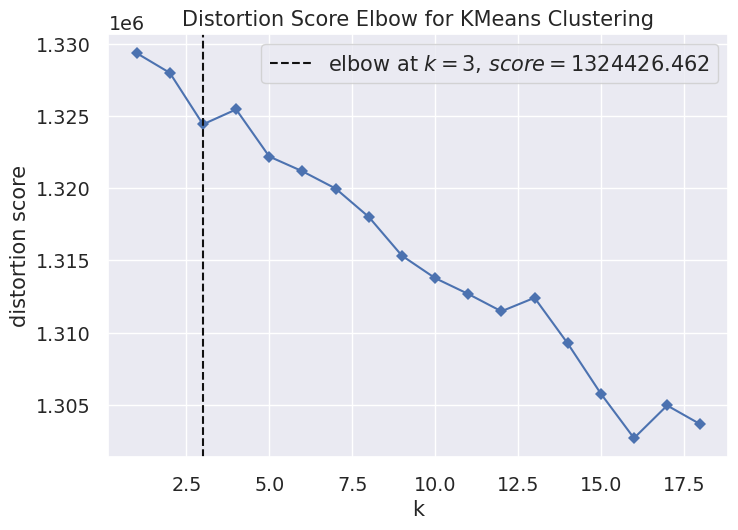

In [51]:
# Elbow Method to find optimal k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 19), timings=False)
visualizer.fit(mca_data)
visualizer.show()

# Get optimal k from the Elbow method
optimal_k = visualizer.elbow_value_

In [52]:
optimal_k

3

### K-means clustering

In [53]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, max_iter=100).fit(mca_data)
 
# extract centroids of clusters into a dataframe
centers = kmeans.cluster_centers_

# extract cluster labels
labels = kmeans.labels_ 

# Step 5: Cluster Analysis

### Analyzing clusters characteristics

In [54]:
cluster_characteristics = []
size_of_clusters = []

for i in range(optimal_k):    
    cluster_data = mca_data[labels == i]
    cluster_size = len(cluster_data)    
    cluster_center = centers[i]
    avg_distance = np.mean(np.linalg.norm(cluster_data - cluster_center, axis=1))    
    cluster_characteristics.append({
        "Cluster": i,        
        "Size": cluster_size,
        "Avg Distance": avg_distance,    
    })
    
cluster_characteristics

[{'Cluster': 0, 'Size': 13011, 'Avg Distance': 7.617198351812614},
 {'Cluster': 1, 'Size': 1694, 'Avg Distance': 7.144141798983244},
 {'Cluster': 2, 'Size': 6, 'Avg Distance': 1.0072321010054053}]

### Silhouette Score, Davies-Bouldin Index, Variance Ratio Criterion, Within-Cluster Sum of Squares (WCSS)

In [55]:
silhouette_avg = silhouette_score(mca_data, kmeans.labels_)
print('Silhouette Score:', round(silhouette_avg, 4))

db_index = davies_bouldin_score(mca_data, kmeans.labels_)
print('Davies-Bouldin Index:', round(db_index, 4))

ch_score = calinski_harabasz_score(mca_data, kmeans.labels_)
print('Calinski-Harabasz Index (Variance Ratio Criterion):', round(ch_score, 4))

wcss = kmeans.inertia_
print('Within-Cluster Sum of Squares (WCSS):', round(wcss, 4))

Silhouette Score: -0.0068
Davies-Bouldin Index: 6.5214
Calinski-Harabasz Index (Variance Ratio Criterion): 26.7092
Within-Cluster Sum of Squares (WCSS): 1324546.4781


### Cluster Visualization

In [56]:
df['CLUSTERS'] = kmeans.labels_

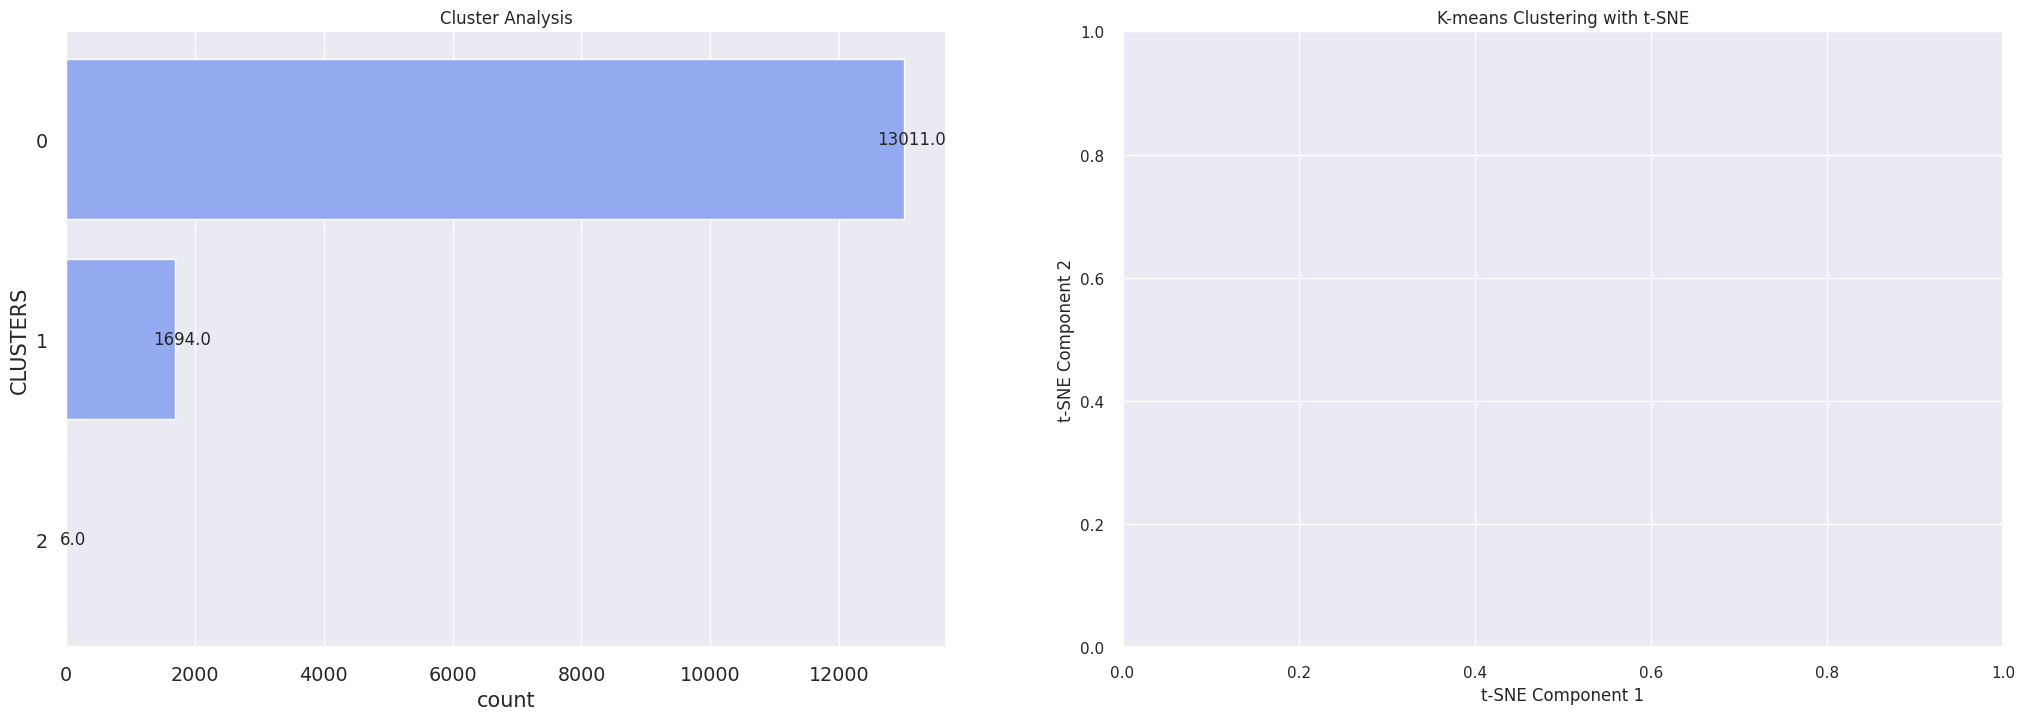

In [57]:
data = [len(df[df['CLUSTERS'] == feature]) for feature in df['CLUSTERS'].value_counts().index]
clusters = df['CLUSTERS'].unique()
labels = [f'CLUSTER: {clusters[i]}' for i in range(len(clusters))]

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
sns.set(font_scale=1)
ax = sns.countplot(y='CLUSTERS', data=df, order=clusters, color='#83A2FF')

# Display counts on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_width()), 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='center', va='center', 
                xytext=(5, 0), 
                textcoords='offset points')

plt.title('Cluster Analysis')
plt.ylabel('CLUSTERS')

# Visualization of kmeans with TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(mca_data)

for i in range(optimal_k):
    plt.scatter(tsne_results[labels == i][:, 0], 
                tsne_results[labels == i][:, 1], label=f'Cluster {i + 1}')
    
plt.subplot(1, 2, 2)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering with t-SNE')
plt.legend(loc ='best')
plt.show()

In [58]:
def cluster_profile(df):
    profiles = {}
    
    for column in df.columns:
        if column != 'CLUSTERS':
            profiles[column] = df[column].mode()[0]
    
    return profiles

In [59]:
cluster_profile = df.groupby('CLUSTERS').apply(cluster_profile)
cluster_profile_df = pd.DataFrame(cluster_profile.tolist(), index=cluster_profile.index)

cluster_profile_df

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
CLUSTERS,,,,,,,,,,,
0,MALE,B2,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,20-29,2012,May,WASHINGTON ST
1,MALE,A1,YES,W(White),Med,"INVESTIGATE, PERSON",A1,20-29,2011,May,BOYLSTON ST
2,MALE,B3,YES,B(Black),Med,"INVESTIGATE, PERSON",B3,20-29,2014,November,BICKNELL ST
